In [27]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [28]:
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
roi_names =['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC','rRSC','lTOS','rTOS','lEBA','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}

In [29]:
sub = subjs[1]
#sub = 'all'
j = 90 # face
dif = nib.load(output_dir + 'image_data\\vis\\dif-' + sub + '-c' + str(j) + '.nii.gz') 
dif = nilearn.image.resample_img(dif, target_shape=(79, 95, 69), target_affine=dif.affine)
dif = np.array(dif.dataobj)
#dif = dif[6:91-6, 7:109-7, 11:91-11]
dif_rois = []
no_roi = np.ones((79, 95, 69), dtype=np.uint8)
for roi_name in roi_names:
    roi = nib.load(roi_dir + roi_name + '.img')
    roi = np.array(roi.dataobj)
    no_roi[np.nonzero(roi)] = 0
    tmp = dif[np.nonzero(roi)]
    tmp[tmp == 0.0] = np.nan
    dif_rois.append(np.nanmedian(tmp))

C:\Users\mahkh\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [30]:
dif_rois = np.array(dif_rois)
tmp = dif[np.nonzero(no_roi)]
tmp[tmp == 0.0] = np.nan
print('rest' + ':', np.round(np.nanmedian(tmp), 8)) 
for i, roi_name in enumerate(roi_names): 
    print(roi_name + ':', np.round(dif_rois[i], 8))

rest: -0.00053056
lFFA: -0.00110267
rFFA: -0.0015567
lOFA: 0.00211962
rOFA: nan
lSTS: 0.00127945
rSTS: -0.00179367
lLOC: -0.00062847
rLOC: 0.0021145
lPPA: -0.00064378
rPPA: -0.00202541
lRSC: -0.00090129
rRSC: -0.00288387
lTOS: 0.00078815
rTOS: nan
lEBA: -0.00099762
rEBA: 8.388e-05


In [31]:
def get_prop(ig_type):
    igs = nib.load(output_dir + 'image_data\\vis\\' + ig_type + '-' + sub + '-c' + str(j) + '.nii.gz') 
    igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
    igs = np.array(igs.dataobj)
    #igs = igs[6:91-6, 7:109-7, 11:91-11]

    tmp = igs.reshape(-1)
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    p_pos = np.nanpercentile(tmp, 90)
    print("p_90", p_pos)
    p_neg = np.nanpercentile(tmp, 10)
    print("p_10", p_neg)

    igs_rois = []
    all_prop_pos = []
    all_prop_neg = []
    no_roi = np.ones((79, 95, 69), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '.img')
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)].copy()
        tmp[tmp == 0.0] = np.nan
        tmp = tmp[~np.isnan(tmp)]
        igs_rois.append(np.nanmedian(tmp))
        prop = 0.0
        for x in tmp:
            if x >= p_pos:
                prop += 1
        if len(tmp) > 0:
            all_prop_pos.append(prop/len(tmp))
        else:
            all_prop_pos.append(0.0)
        prop = 0.0
        for x in tmp:
            if x <= p_neg:
                prop += 1
        if len(tmp) > 0:
            all_prop_neg.append(prop/len(tmp))
        else: 
            all_prop_neg.append(0.0)
    igs_rois = np.array(igs_rois)   
    tmp = igs[np.nonzero(no_roi)].copy()
    tmp[tmp == 0.0] = np.nan
    ##
    prop = 0.0
    for x in tmp:
        if x > p_pos:
            prop += 1
    all_prop_pos.append(prop/len(tmp))
    ##
    print('\n')
    ##
    prop = 0.0
    for x in tmp:
        if x < p_neg:
            prop += 1
    all_prop_neg.append(prop/len(tmp))
    ##
    print('\nMedian IGs:')   
    print('rest' + ':', np.round(np.nanmedian(tmp), 8))
    for i, roi_name in enumerate(roi_names): 
        print(roi_name + ':', np.round(igs_rois[i], 8))
    return all_prop_pos, all_prop_neg

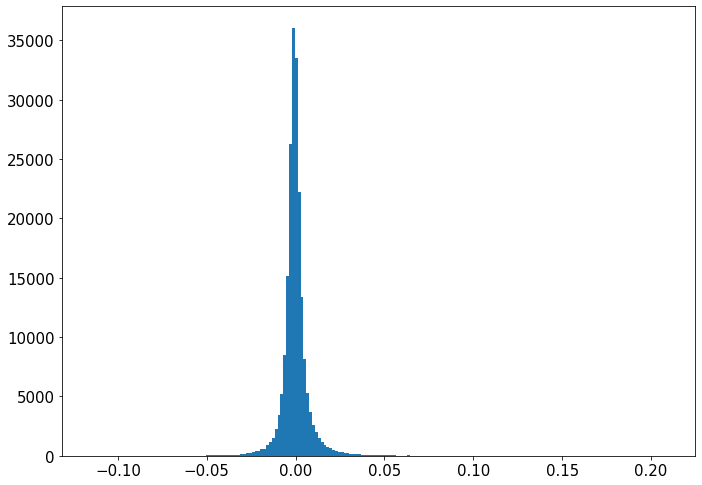

In [32]:
igs = nib.load(output_dir + 'image_data/vis/dif-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]

tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()

In [33]:
def plot_igs(x, t, y):
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    plt.rc('font', size=15)
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y)
    ax.set_xlabel('Brain ROIs')
    ax.set_title(sub + ': Face ' + t)
    ax.bar(roi_names+['rest'], x)
    plt.show()

p_90 8.903308662411291e-06
p_10 -9.352622782898834e-06



Median IGs:
rest: -0.0
lFFA: -8e-08
rFFA: 0.0
lOFA: 3e-08
rOFA: 0.0
lSTS: -1.87e-06
rSTS: -0.0
lLOC: 0.0
rLOC: 0.0
lPPA: 0.0
rPPA: -1.4e-07
lRSC: 1.06e-06
rRSC: 1.6e-07
lTOS: -1.4e-07
rTOS: -0.0
lEBA: -1.06e-06
rEBA: 0.0


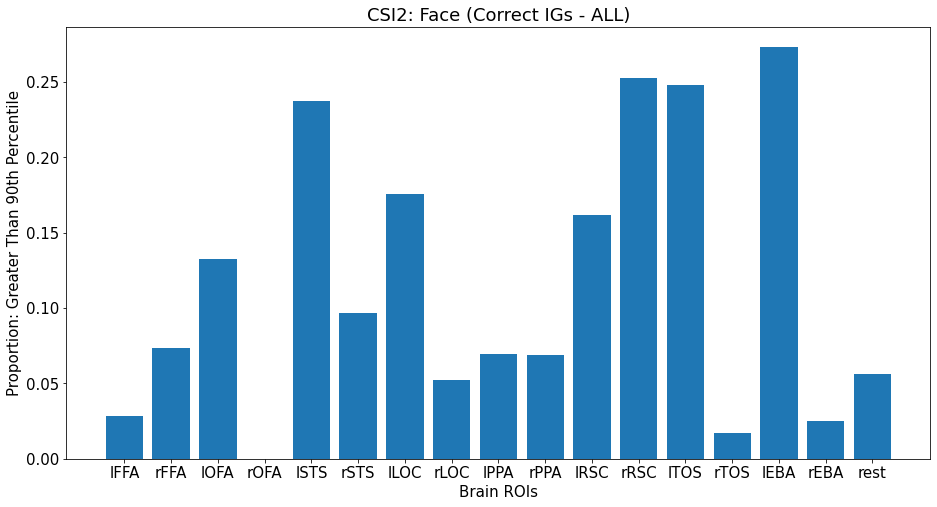

p_90 2.1393798306235112e-05
p_10 -2.1028416085755453e-05



Median IGs:
rest: 0.0
lFFA: -0.0
rFFA: 0.0
lOFA: 1.3e-07
rOFA: 0.0
lSTS: -4.38e-06
rSTS: -0.0
lLOC: 0.0
rLOC: 0.0
lPPA: 5.1e-07
rPPA: 7.3e-07
lRSC: 2.8e-06
rRSC: 3.9e-07
lTOS: 7.4e-07
rTOS: -0.0
lEBA: -2.2e-06
rEBA: 0.0


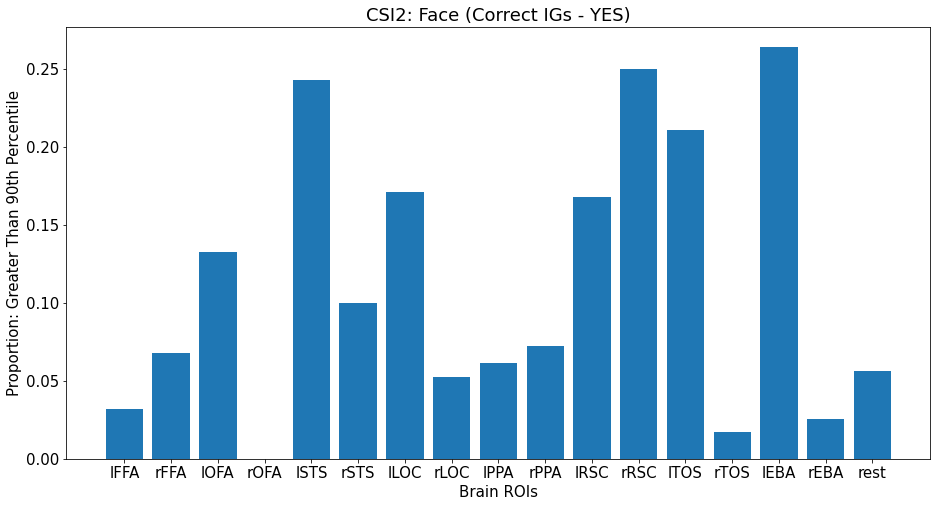

p_90 5.46090564057522e-06
p_10 -6.1388695939967874e-06



Median IGs:
rest: -0.0
lFFA: -1.3e-07
rFFA: 0.0
lOFA: 2e-08
rOFA: 0.0
lSTS: -1.24e-06
rSTS: -0.0
lLOC: -0.0
rLOC: 0.0
lPPA: -1.6e-07
rPPA: -1.8e-07
lRSC: 5.3e-07
rRSC: -2e-08
lTOS: 4e-08
rTOS: -0.0
lEBA: -8.4e-07
rEBA: 0.0


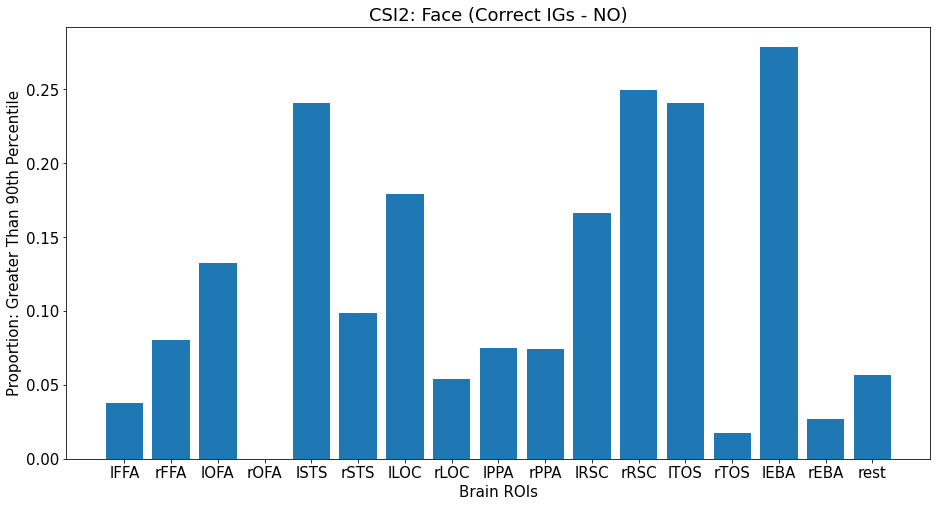

In [34]:
all_prop_pos, all_prop_neg = get_prop(ig_type='igs')
plot_igs(all_prop_pos, '(Correct IGs - ALL)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(All Correct IGs)', 'Proportion: Less Than 10th Percentile')
all_prop_pos, all_prop_neg = get_prop(ig_type='igs-p')
plot_igs(all_prop_pos, '(Correct IGs - YES)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(YES Correct IGs)', 'Proportion: Less Than 10th Percentile')
all_prop_pos, all_prop_neg = get_prop(ig_type='igs-n')
plot_igs(all_prop_pos, '(Correct IGs - NO)', 'Proportion: Greater Than 90th Percentile')
#plot_igs(all_prop_neg, '(NO Correct IGs)', 'Proportion: Less Than 10th Percentile')
